In [42]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

path = str(Path(Path('thermo.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import scipy
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from tools.cbook import pickle2Obj
import tools
from tools.FV3_tools import read_solo_fields
from tools.CM1_tools import read_cm1_fields

from pltbook import nice_clevels, nice_mxmnintvl, container, plot_contour_row

import matplotlib.colors as mcolors

cmap_data = [(1.0, 1.0, 1.0),
         (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
         (0.0, 1.0, 1.0),
         (0.0, 0.8784313797950745, 0.501960813999176),
         (0.0, 0.7529411911964417, 0.0),
         (0.501960813999176, 0.8784313797950745, 0.0),
         (1.0, 1.0, 0.0),
         (1.0, 0.6274510025978088, 0.0),
         (1.0, 0.0, 0.0),
         (1.0, 0.125490203499794, 0.501960813999176),
         (0.9411764740943909, 0.250980406999588, 1.0),
         (0.501960813999176, 0.125490203499794, 1.0),
         (0.250980406999588, 0.250980406999588, 1.0),
         (0.125490203499794, 0.125490203499794, 0.501960813999176),
         (0.125490203499794, 0.125490203499794, 0.125490203499794),
         (0.501960813999176, 0.501960813999176, 0.501960813999176),
         (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
         (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
         (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
         (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
         (0.4000000059604645, 0.20000000298023224, 0.0)]

_nthreads = 2

# draw filled contours.
wclevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 60, 70]

tclevs = list(-40.0 + 2*np.arange(41))

pclevs = list(-15.0 + np.arange(31))

dclevs = list(-20.0 + np.arange(41))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### SOLO

In [108]:
paths = {}
paths['solo1'] = '/work/wicker/Odin_scr/solo/bubble_3km_dt20_hdd125_C2000_00'
paths['solo2'] = '/work/wicker/Odin_scr/solo/bubble_2km_dt12_hdd125_C2000_00'
paths['solo3'] = '/work/wicker/Odin_scr/solo/bubble_1km_dt06_hdd125_C2000_00'

# ksplit = 4
# paths['solo1'] = '/work/wicker/Odin_scr/solo/bubble_3km_remap_hdd125_C2000_00'
# paths['solo2'] = '/work/wicker/Odin_scr/solo/bubble_3km_remap_hdd012_C2000_00'
# paths['solo3'] = '/work/wicker/Odin_scr/solo/bubble_3km_remap_hdd001_C2000_00'

solo_hdd125 = [read_solo_fields(paths['solo1'], vars = ['+','div2d'], file_pattern=None, ret_dbz=False, ret_ds=True),
               read_solo_fields(paths['solo2'], vars = ['+','div2d'], file_pattern=None, ret_dbz=False, ret_ds=True),
               read_solo_fields(paths['solo3'], vars = ['+','div2d'], file_pattern=None, ret_dbz=False, ret_ds=True)]

------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/solo/bubble_3km_dt20_hdd125_C2000_00/atmos_hifreq.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/Odin_scr/solo/bubble_3km_dt20_hdd125_C2000_00/atmos_hifreq.nc 

 -->Computing finite difference 2D divergence

 Completed reading in:  /work/wicker/Odin_scr/solo/bubble_3km_dt20_hdd125_C2000_00/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/solo/bubble_2km_dt12_hdd125_C2000_00/atmos_hifreq.nc
--------------------------------------------

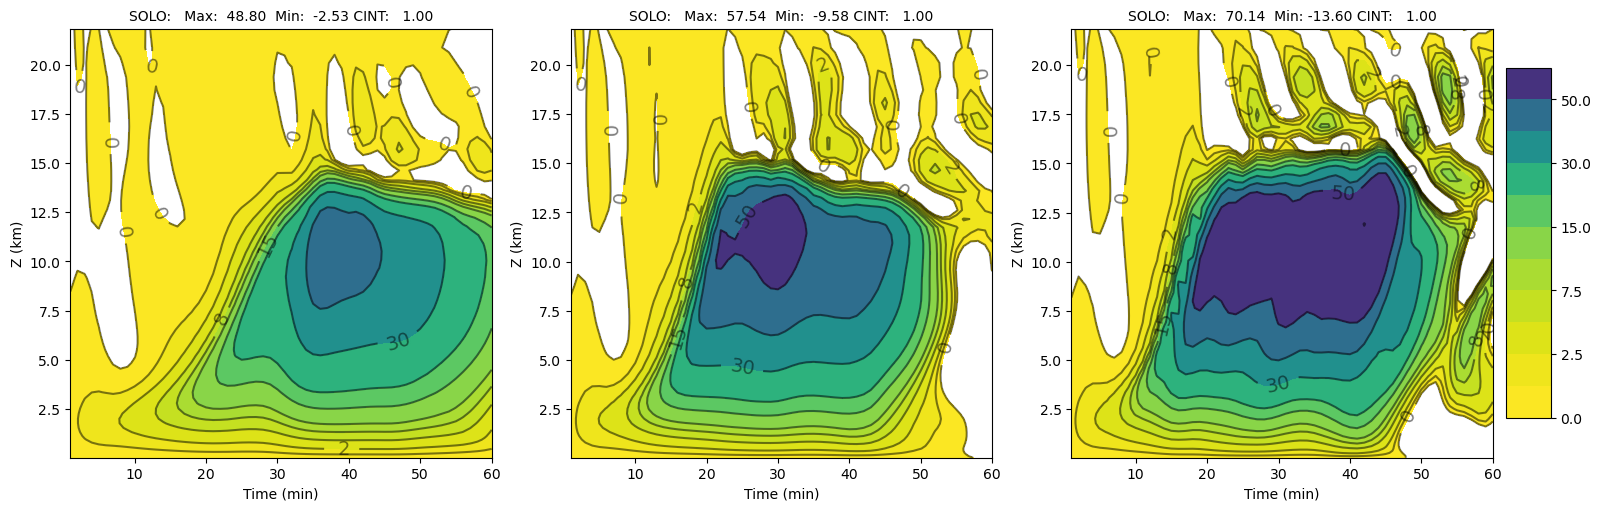

In [41]:
#

loc = [[32, 32], [48, 48], [96, 96]]

#loc = [[32, 32], [32, 32], [32, 32]]

time1 = solo_hdd125[0][1]['time']/60.
time  = np.tile(time1, (60,1)).transpose()

fields = []

for n in np.arange(3):

    iloc, jloc = loc[n][:]

    w_col = solo_hdd125[n][0]['w'][:,:,jloc, iloc]
    z_col = solo_hdd125[n][0]['hgt'][:,:,jloc, iloc] * 0.001

    fields.append(container(time, z_col, w_col))

plot_contour_row(fields, levels=wclevs, title='SOLO', xlabel='Time (min)', ylabel='Z (km)', extra_levels=wclevs, cmap=plt.cm.viridis_r, cint=2.5);


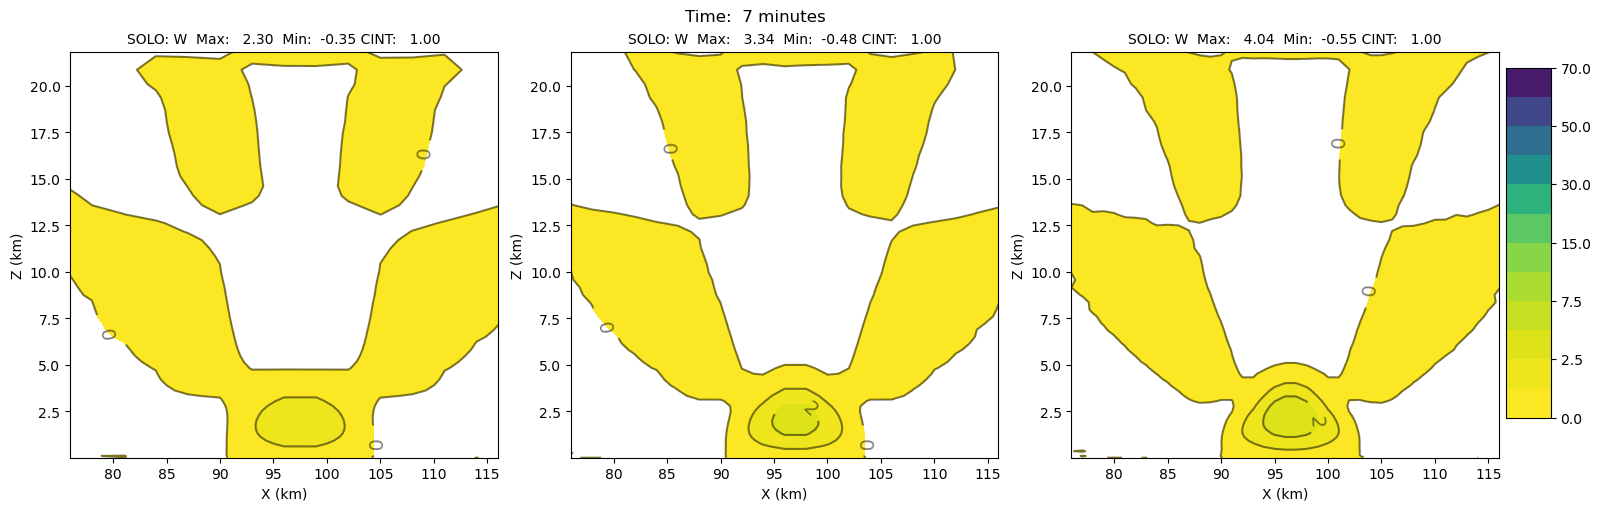

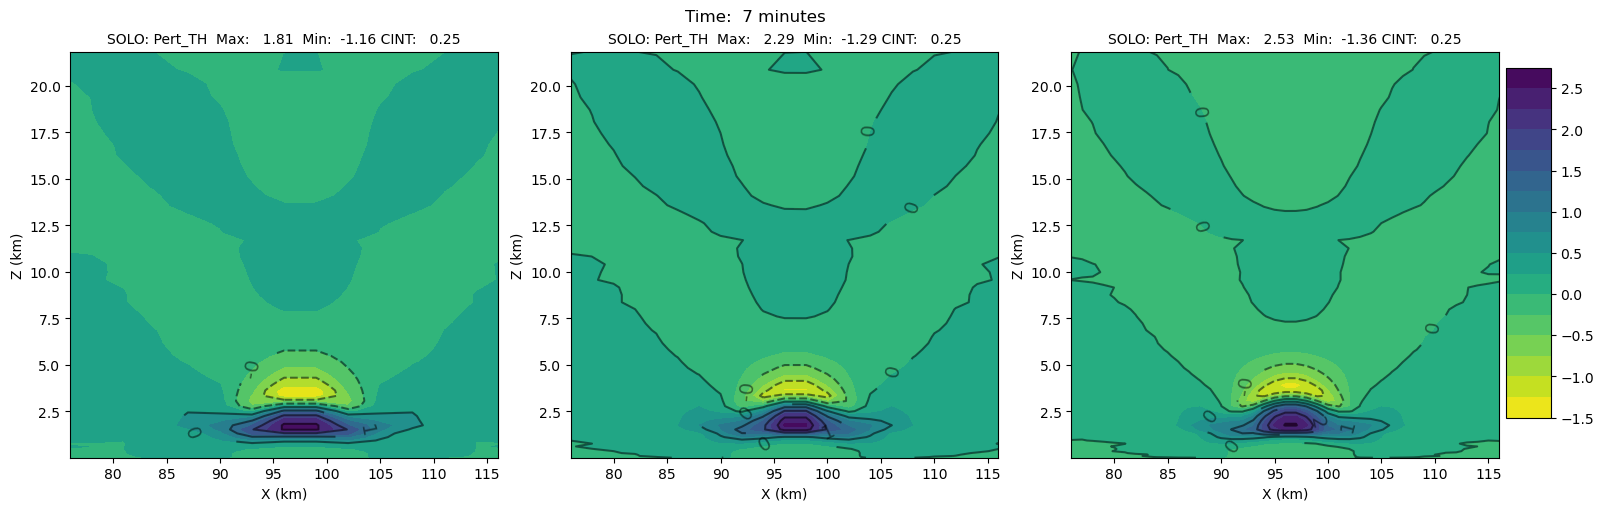

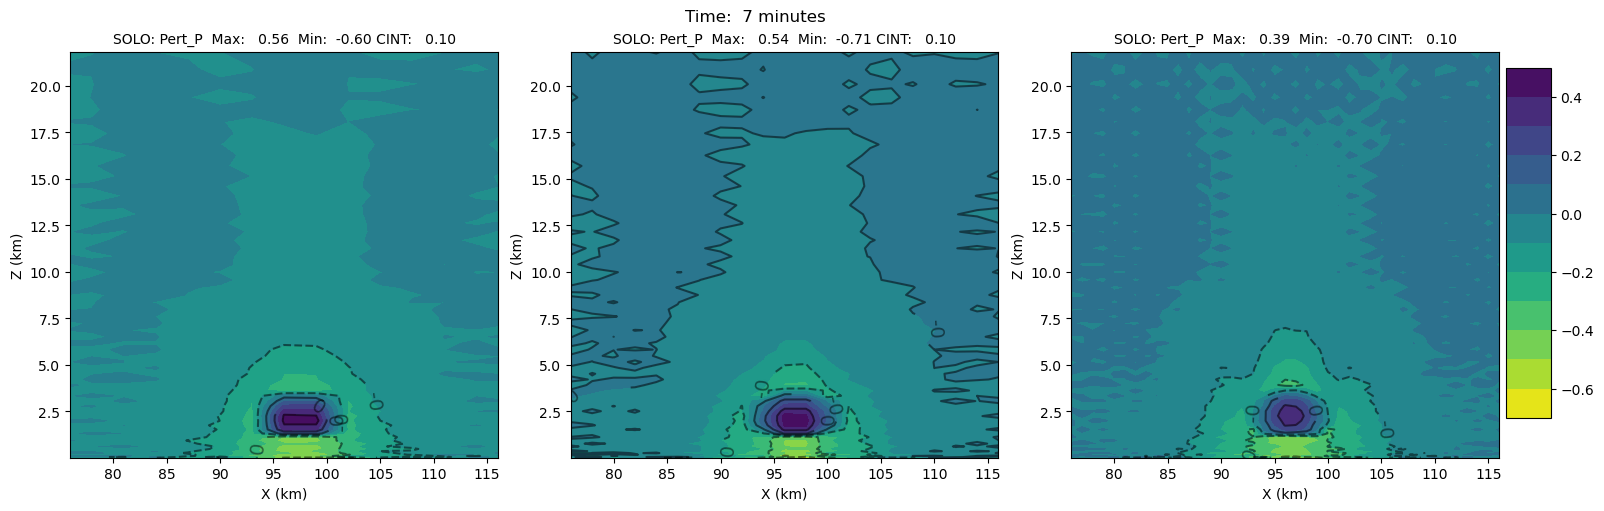

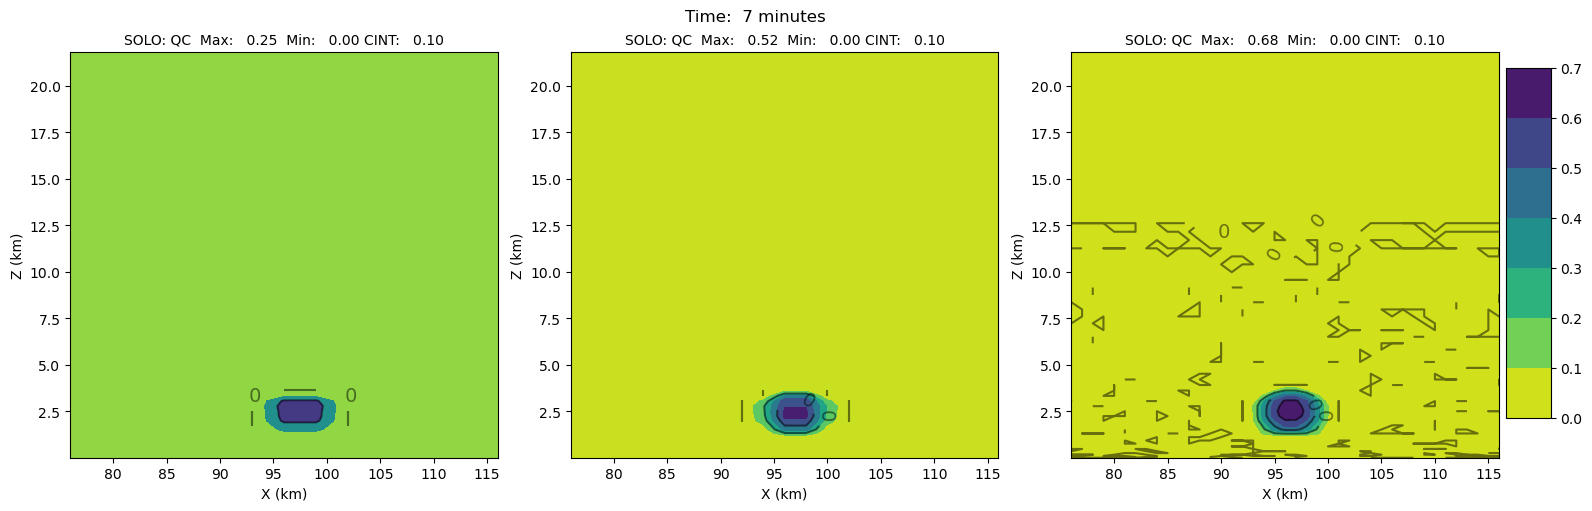

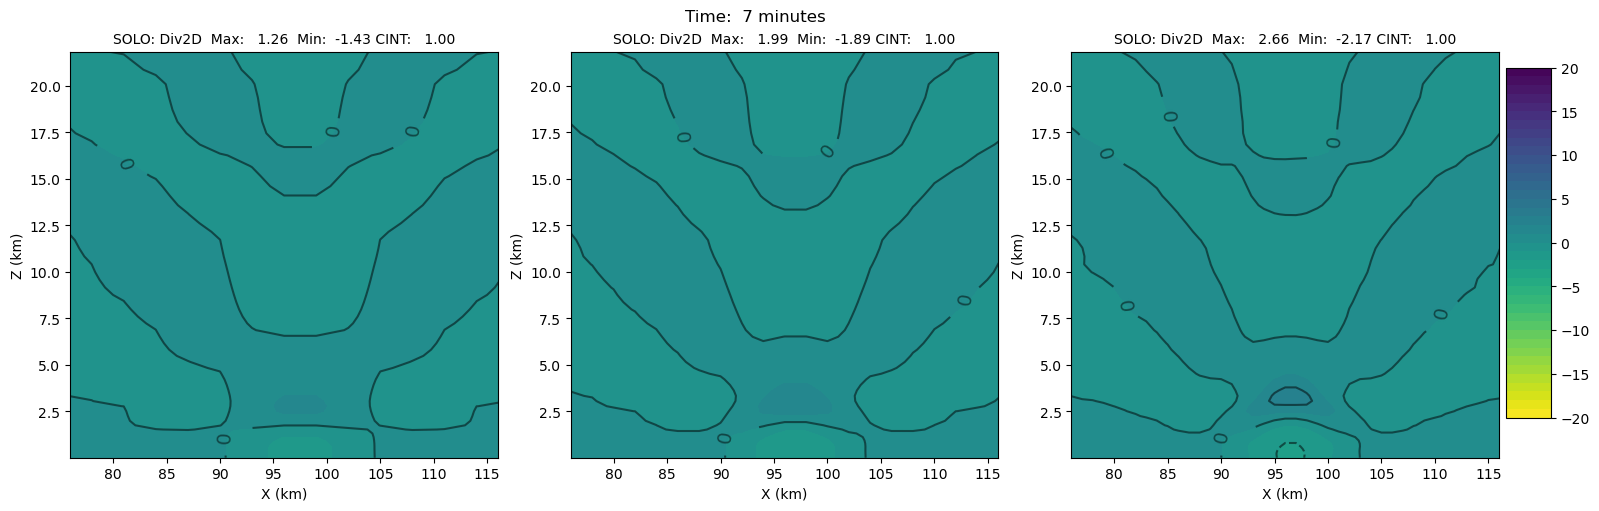

In [116]:
# SOLO XZ

time1 = solo_hdd125[0][1]['time']/60.

t0 = 6

loc = [ [t0, 32], [t0, 48 ], [t0, 96] ]

res = [3,2,1]

title = 'SOLO'

wlist, dlist, thlist, pplist, qclist = [],[],[],[],[]

supertitle = "Time:  %d minutes" % time1[tloc]

for n in np.arange(3):

    tloc, jloc = loc[n][:]

    suptitle = "Time:  %d minutes" % int(time1[tloc])

    z_col = solo_hdd125[n][0]['hgt'][tloc,:,jloc, :] * 0.001
    x1 = solo_hdd125[n][1]['grid_xt'].values*res[n]
    x  = np.tile(x1, (z_col.shape[0],1))

    w  = solo_hdd125[n][0]['w'][tloc,:,jloc,:]
    d  = solo_hdd125[n][0]['div2d'][tloc,:,jloc,:] / res[n]
    th = solo_hdd125[n][0]['pert_th'][tloc,:,jloc,:]
    pp = solo_hdd125[n][0]['pert_nh'][tloc,:,jloc,:]/100.
    qc = solo_hdd125[n][0]['qc'][tloc,:,jloc,:]*1000.
        
    wlist.append(container(x, z_col, w))
    dlist.append(container(x, z_col, d))
    thlist.append(container(x, z_col, th))
    pplist.append(container(x, z_col, pp))
    qclist.append(container(x, z_col, qc))
        
# Compare exact and calculated derivative:

plot_contour_row(wlist,  levels=wclevs, title=title, suptitle=suptitle, var='W',       range=[76,116], xlabel='X (km)', ylabel='Z (km)', cl_levels=wclevs);
plot_contour_row(thlist,                title=title, suptitle=suptitle, var='Pert_TH', range=[76,116], xlabel='X (km)', ylabel='Z (km)', cint=0.25)# cl_levels=tclevs[::2]);
plot_contour_row(pplist,                title=title, suptitle=suptitle, var='Pert_P',  range=[76,116], xlabel='X (km)', ylabel='Z (km)', cint=0.1);
plot_contour_row(qclist,                title=title, suptitle=suptitle, var='QC',      range=[76,116], xlabel='X (km)', ylabel='Z (km)', cint=0.1);
plot_contour_row(dlist,  levels=dclevs, title=title, suptitle=suptitle, var='Div2D',   range=[76,116], xlabel='X (km)', ylabel='Z (km)');


### CM1 - 3km

In [31]:
paths = {}
paths['cm1_3km_hdd125'] = '/work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_dt05_hdd125_C2000_00'
paths['cm1_2km_hdd125'] = '/work/wicker/Odin_scr/cm1r20.3/run/bubble_2km_dt03_hdd125_C2000_00'
paths['cm1_1km_hdd125'] = '/work/wicker/Odin_scr/cm1r20.3/run/bubble_1km_dt01_hdd125_C2000_00'

cm1_hdd125 = [read_cm1_fields(paths['cm1_3km_hdd125'] , vars = ['+','div2d','uns_div2d'], file_pattern=None, ret_dbz=False, ret_ds=True),
              read_cm1_fields(paths['cm1_2km_hdd125'] , vars = ['+','div2d','uns_div2d'], file_pattern=None, ret_dbz=False, ret_ds=True),
              read_cm1_fields(paths['cm1_1km_hdd125'] , vars = ['+','div2d','uns_div2d'], file_pattern=None, ret_dbz=False, ret_ds=True)]

------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_dt05_hdd125_C2000_00/cm1out.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_dt05_hdd125_C2000_00/cm1out.nc 

 -->Computing unstaggered finite difference 2D divergence

 -->Computing finite difference 2D divergence

 Completed reading in:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_3km_dt05_hdd125_C2000_00/cm1out.nc 

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/cm1r20.3/run/bubble_2km_dt03_hdd

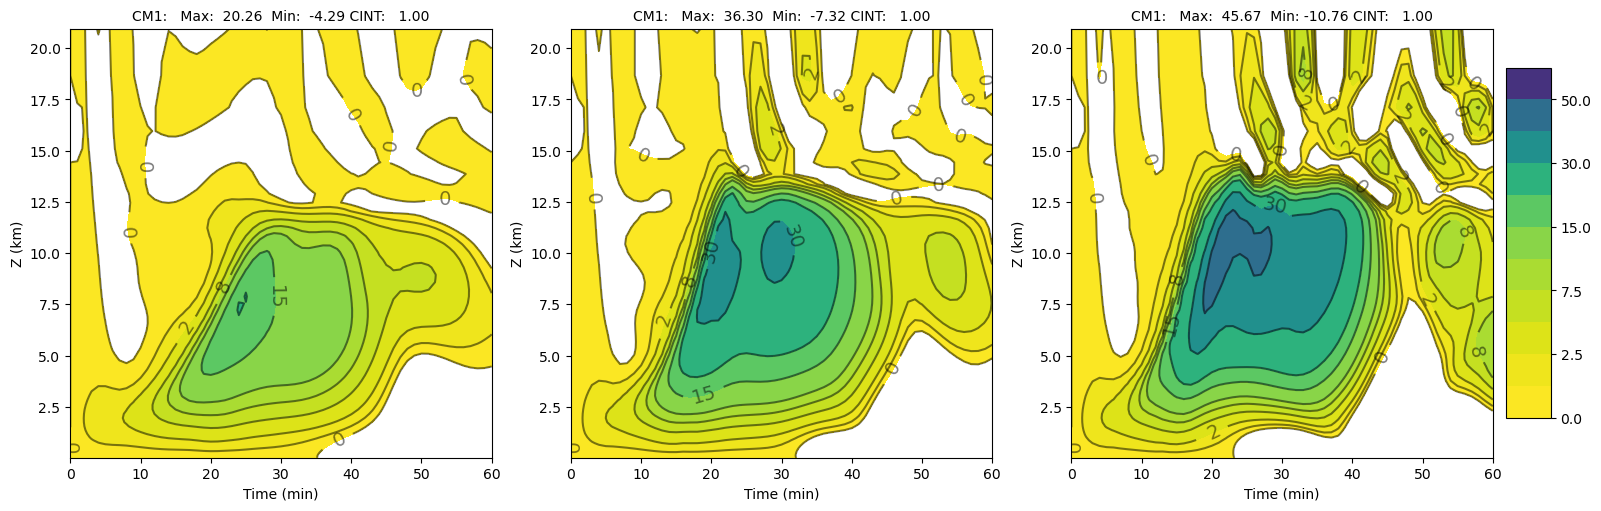

In [40]:
# CM1 multi-resolution plots
#
time1 = cm1_hdd125[0][1]['time']/60.
time  = np.tile(time1, (60,1)).transpose()

fields = []

for n in np.arange(3):

    if n == 0:
        iloc, jloc = 32, 32
    elif n == 1:
        iloc, jloc = 48, 48
    else:
        iloc, jloc = 96, 96

    w_col = cm1_hdd125[n][0]['w'][:,:,jloc, iloc]
    z1d    = cm1_hdd125[n][1].zh.values[:]
    z_col  = np.tile(z1d, (time1.shape[0],1))

    fields.append(container(time, z_col, w_col))

plot_contour_row(fields, levels=wclevs, title='CM1', xlabel='Time (min)', ylabel='Z (km)', extra_levels=wclevs, cmap=plt.cm.viridis_r);


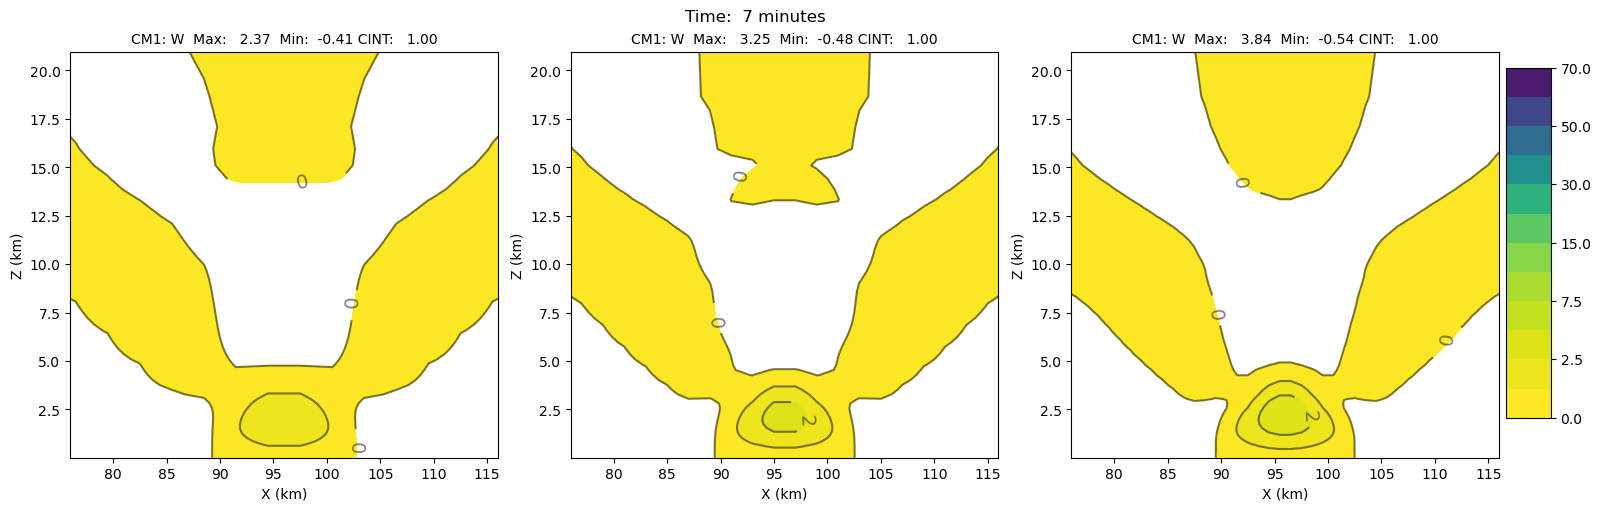

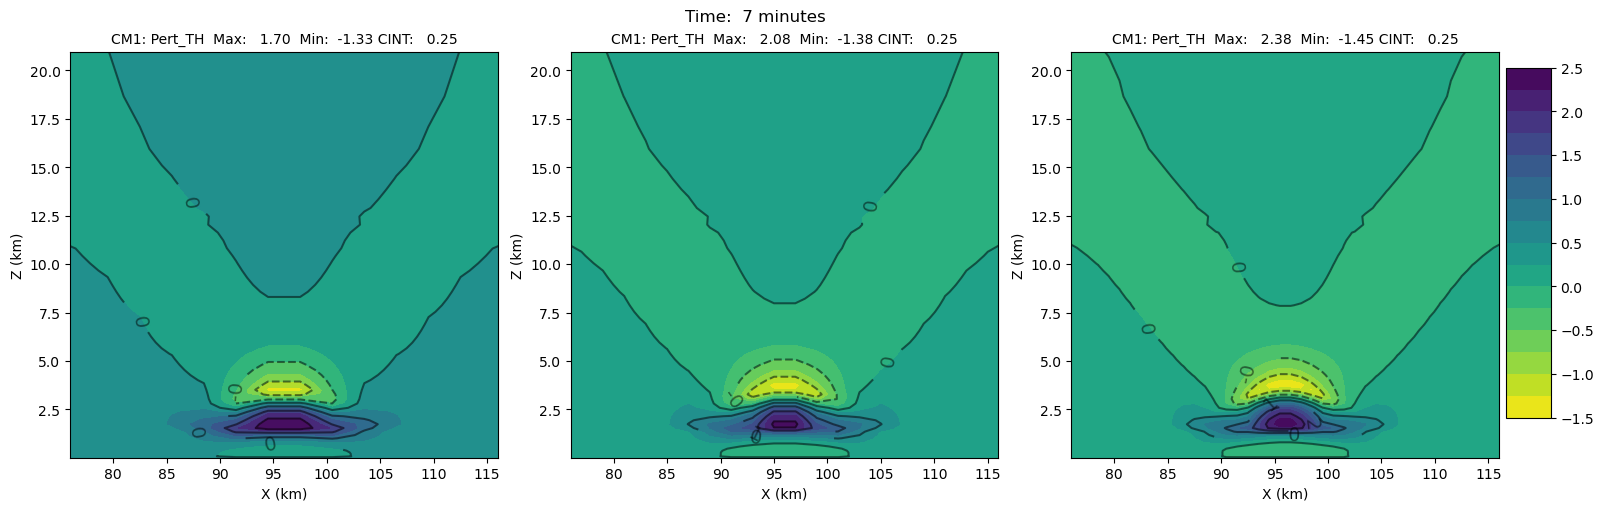

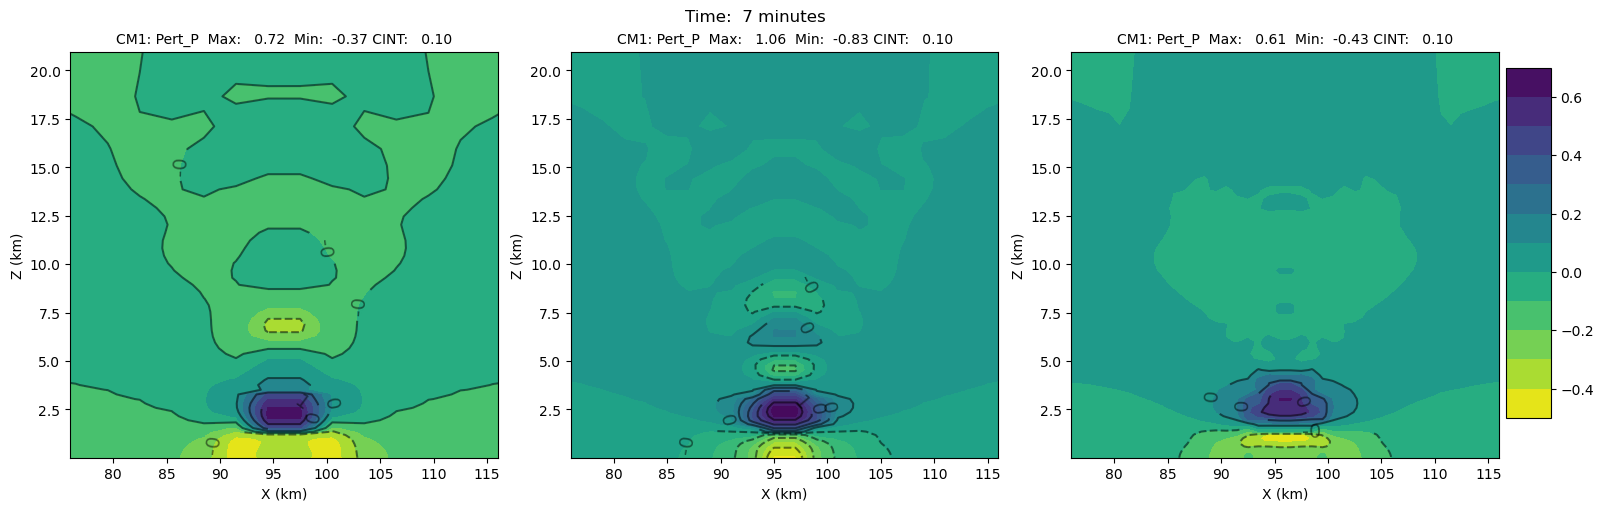

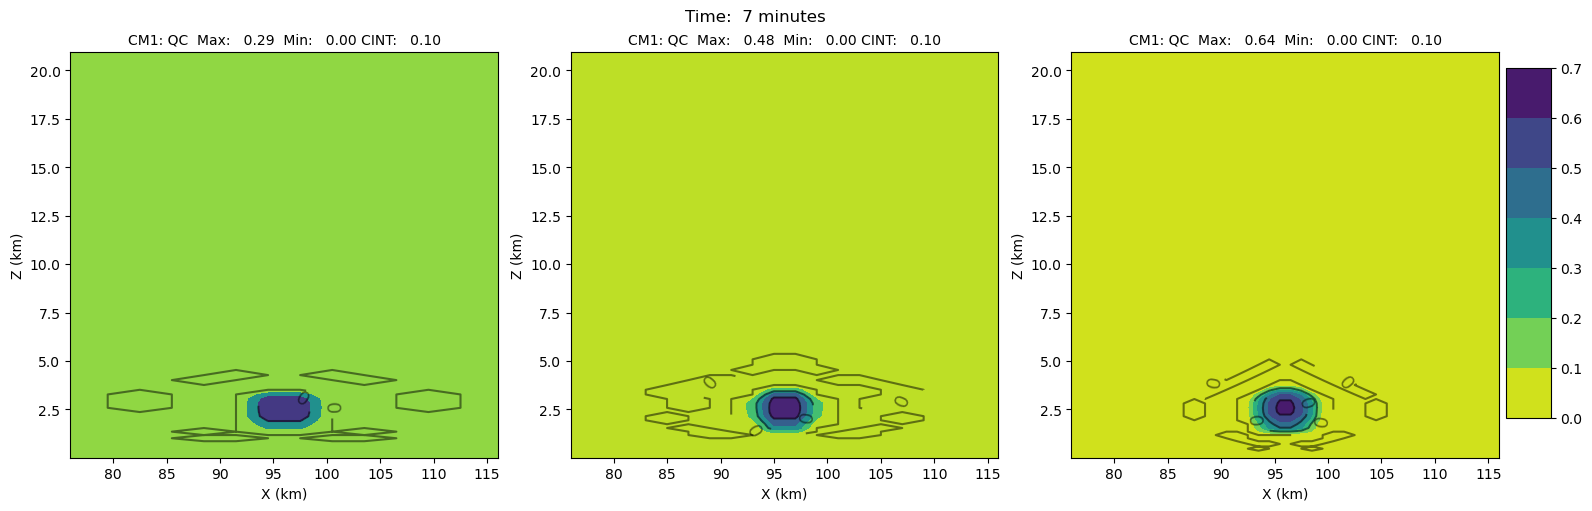

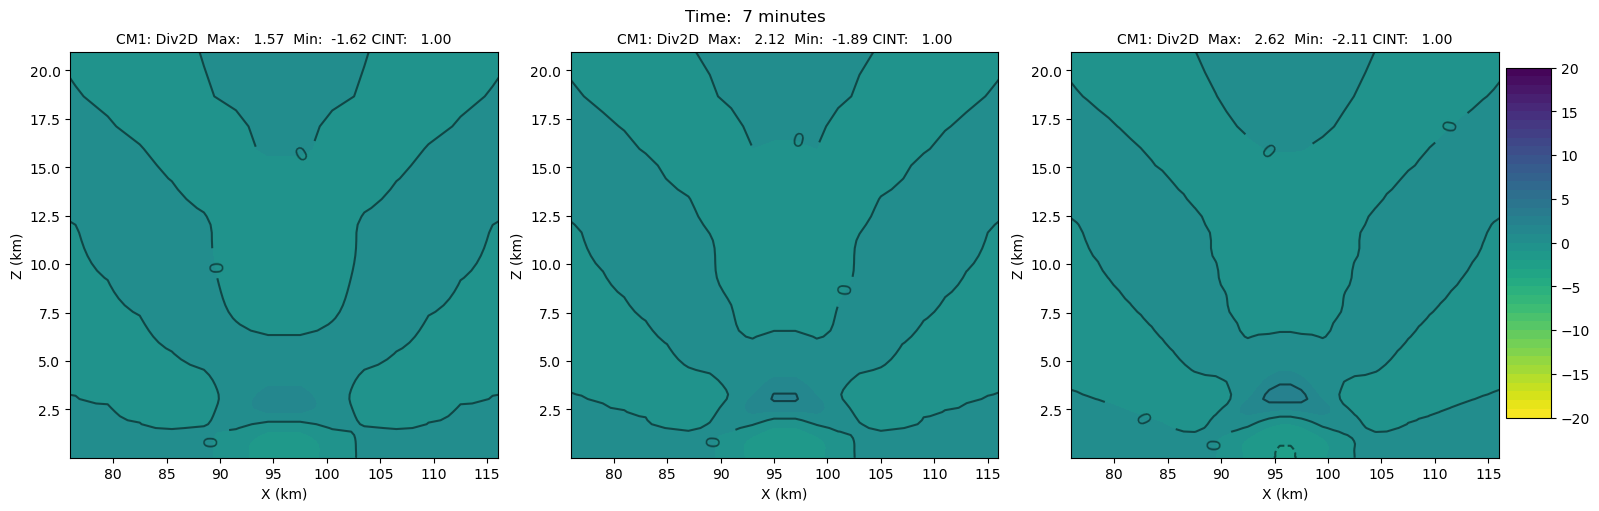

In [117]:
# CM1 plots

t0 = 7

loc = [ [t0, 32], [t0, 48 ], [t0, 96] ]

time1 = cm1_hdd125[0][1]['time']/60.

title='CM1'

wlist = []
dlist = []
thlist = []
pplist = []
qclist = []

for n in np.arange(3):

    tloc, jloc = loc[n][:]

    suptitle = "Time:  %d minutes" % int(time1[tloc])

    z2d = cm1_hdd125[n][0]['hgt'][tloc,:,jloc, :]*0.001
    x1  = cm1_hdd125[n][1]['xh']
    x   = np.tile(x1, (z2d.shape[0],1))
    d   = cm1_hdd125[n][0]['div2d'][tloc,:,jloc,:] 
    w   = cm1_hdd125[n][0]['w'][tloc,:,jloc, :]
    thp = cm1_hdd125[n][0]['pert_th'][tloc,:,jloc, :]
    pp  = cm1_hdd125[n][0]['pert_p'][tloc,:,jloc, :] / 100.
    qc  = cm1_hdd125[n][0]['qc'][tloc,:,jloc, :] * 1000.
        
    wlist.append(container(x, z2d, w))
    dlist.append(container(x, z2d, d))
    thlist.append(container(x, z2d, thp))
    pplist.append(container(x, z2d, pp))
    qclist.append(container(x, z2d, qc))
    
    
# Compare exact and calculated derivative:

plot_contour_row(wlist,  levels=wclevs, title=title, suptitle=suptitle, var='W',       range=[76,116], xlabel='X (km)', ylabel='Z (km)', cl_levels=wclevs);
plot_contour_row(thlist,                title=title, suptitle=suptitle, var='Pert_TH', range=[76,116], xlabel='X (km)', ylabel='Z (km)', cint=0.25)# cl_levels=tclevs[::2]);
plot_contour_row(pplist,                title=title, suptitle=suptitle, var='Pert_P',  range=[76,116], xlabel='X (km)', ylabel='Z (km)', cint=0.1);
plot_contour_row(qclist,                title=title, suptitle=suptitle, var='QC',      range=[76,116], xlabel='X (km)', ylabel='Z (km)', cint=0.1);
plot_contour_row(dlist,  levels=dclevs, title=title, suptitle=suptitle, var='Div2D',   range=[76,116], xlabel='X (km)', ylabel='Z (km)');


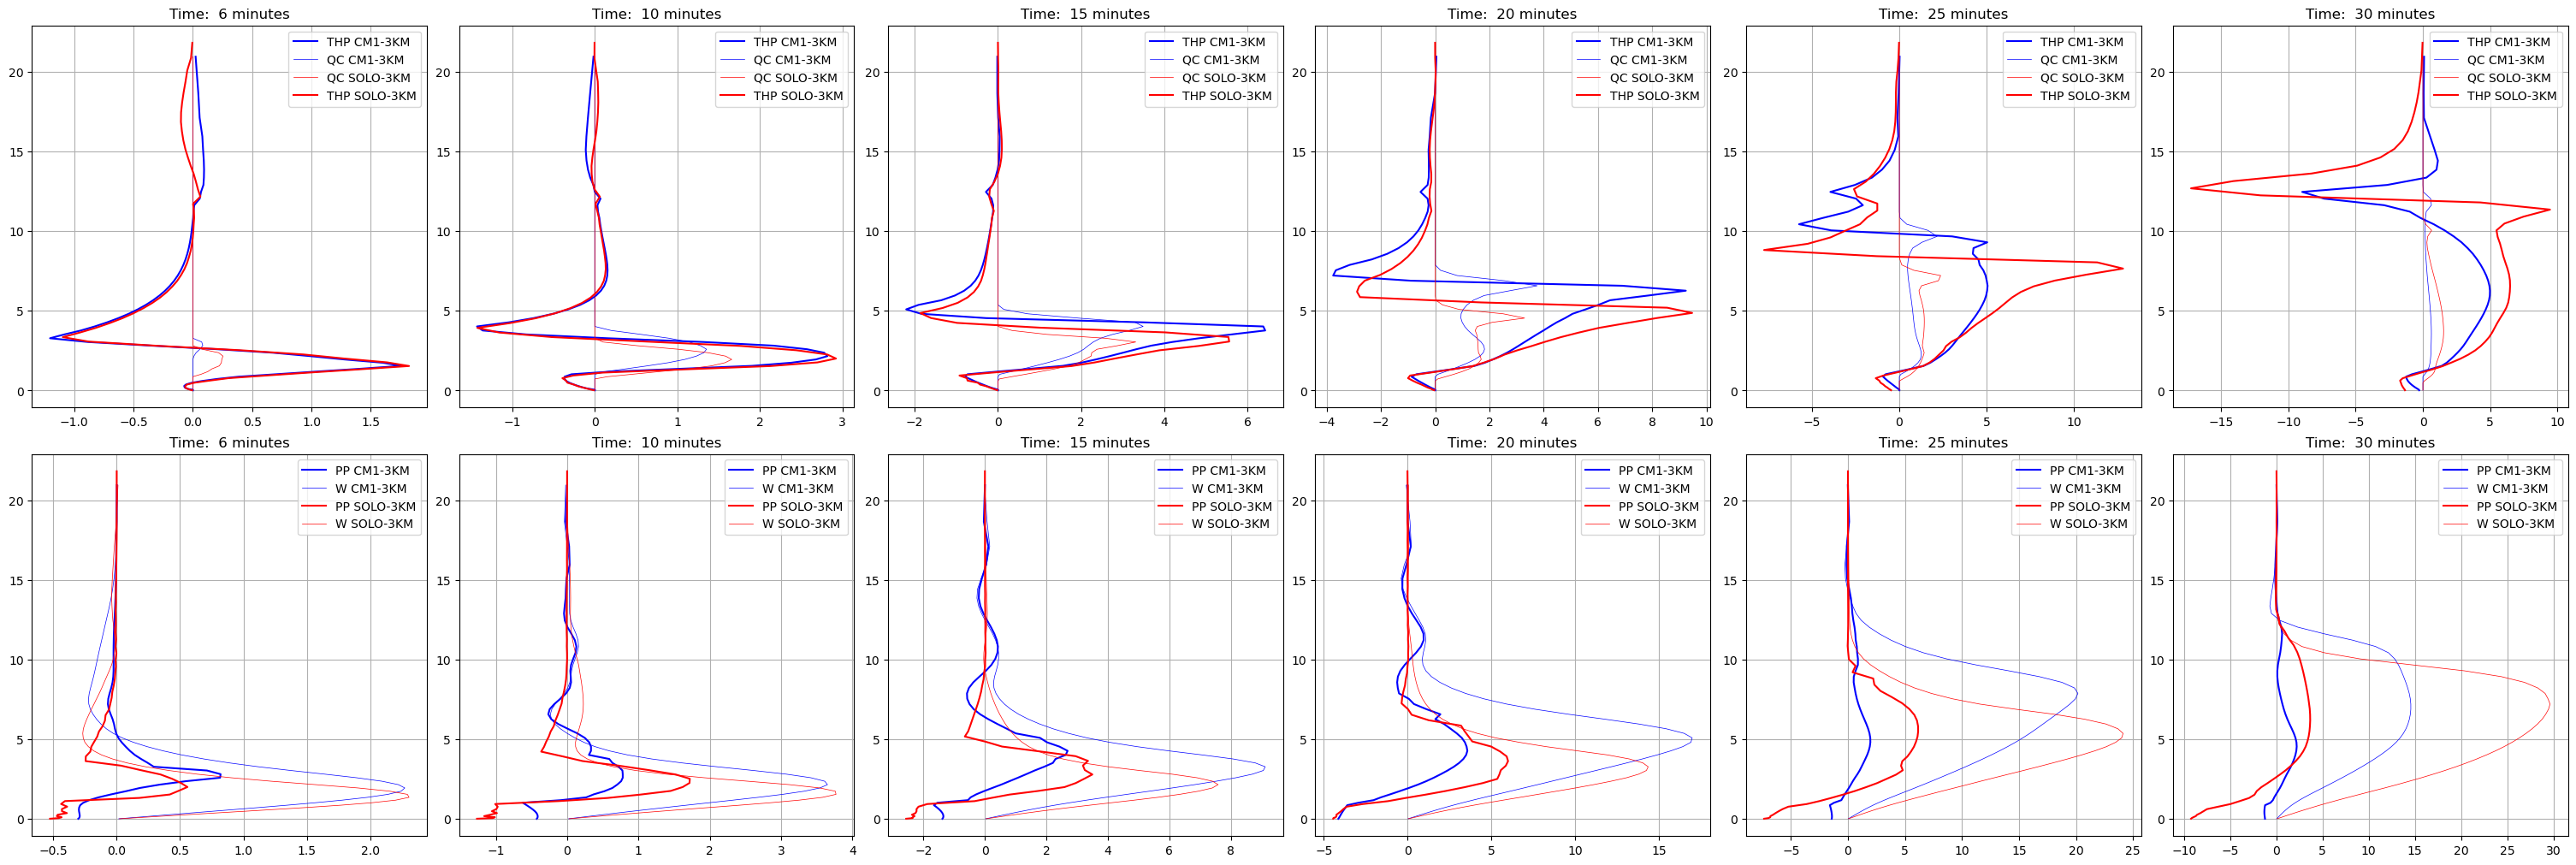

In [159]:
# Updraft Core plots

tplot = [6, 10, 15, 20, 25, 30]

cm1_time = cm1_hdd125[0][1]['time']/60.

title='CM1'

wlist = []
dlist = []
thlist = []
pplist = []
qclist = []

fig, axes = fig, axes = plt.subplots(2,len(tplot), constrained_layout=True, figsize=(5*len(tplot),10))

for n, tloc in enumerate(tplot):

    iloc, jloc = 32, 32

    title = "Time:  %d minutes" % int(cm1_time[tloc])

    z_cm1   = cm1_hdd125[0][0]['hgt'][tloc, :, jloc, iloc]*0.001
    thp_cm1 = cm1_hdd125[0][0]['pert_th'][tloc,:,jloc, iloc]
    pp_cm1  = cm1_hdd125[0][0]['pert_p'][tloc,:,jloc, iloc] / 100.
    qc_cm1  = cm1_hdd125[0][0]['qc'][tloc,:,jloc, iloc] * 1000.
    w_cm1   = cm1_hdd125[0][0]['w'][tloc,:,jloc, iloc]

    z_solo   = solo_hdd125[0][0]['hgt'][tloc-1,:,jloc, iloc] * 0.001
    thp_solo = solo_hdd125[0][0]['pert_th'][tloc-1,:,jloc,iloc]
    pp_solo  = solo_hdd125[0][0]['pert_nh'][tloc,:,jloc,iloc]/100.
    qc_solo  = solo_hdd125[0][0]['qc'][tloc,:,jloc,iloc]*1000.
    w_solo   = solo_hdd125[0][0]['w'][tloc,:, jloc, iloc]

    axes[0,n].plot(thp_cm1, z_cm1, color='b', label='THP CM1-3KM')
    axes[0,n].plot(qc_cm1, z_cm1, color='b', linewidth=0.5, label='QC CM1-3KM')
    axes[0,n].plot(qc_solo, z_cm1, color='r', linewidth=0.5, label='QC SOLO-3KM')
    axes[0,n].plot(thp_solo, z_solo, color='r', label='THP SOLO-3KM')
    axes[0,n].set_title(title)
    axes[0,n].legend()
    axes[0,n].grid()

    axes[1,n].plot(pp_cm1, z_cm1, color='b', label='PP CM1-3KM')
    axes[1,n].plot(w_cm1, z_cm1, color='b', linewidth=0.5, label='W CM1-3KM')
    axes[1,n].plot(pp_solo, z_solo, color='r', label='PP SOLO-3KM')
    axes[1,n].plot(w_solo, z_cm1, color='r', linewidth=0.5, label='W SOLO-3KM')
    axes[1,n].grid()

    axes[1,n].set_title(title)
    axes[1,n].legend()


plt.show()

    # d   = cm1_hdd125[n][0]['div2d'][tloc,:,jloc,:] 
    # w   = cm1_hdd125[n][0]['w'][tloc,:,jloc, :]

    # pp  = cm1_hdd125[n][0]['pert_p'][tloc,:,jloc, :] / 100.
    # qc  = cm1_hdd125[n][0]['qc'][tloc,:,jloc, :] * 1000.


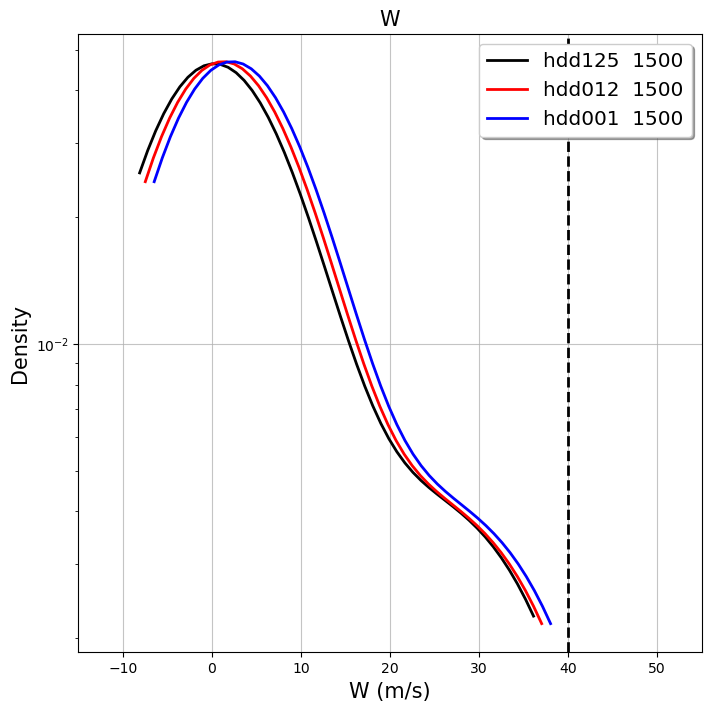

In [56]:
kde_plotter([w_col,w_col2+1.0,w_col3+2.0], ['hdd125','hdd012','hdd001'], ['k','r','b'])
    
plt.show()

In [75]:
paths = {}
paths['solo_hdd125'] = '/work/wicker/Odin_scr/solo/bubble_1km_dt10_hdd125_C2000_00'
paths['solo_hdd012'] = '/work/wicker/Odin_scr/solo/bubble_1km_dt10_hdd012_C2000_00'
paths['solo_hdd001'] = '/work/wicker/Odin_scr/solo/bubble_1km_dt10_hdd001_C2000_00'

solo_1km = [read_solo_fields(paths['solo_hdd125'] , vars = [''], file_pattern=None, ret_dbz=False, ret_ds=True),
            read_solo_fields(paths['solo_hdd012'] , vars = [''], file_pattern=None, ret_dbz=False, ret_ds=True),
            read_solo_fields(paths['solo_hdd001'] , vars = [''], file_pattern=None, ret_dbz=False, ret_ds=True)]

------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/solo/bubble_1km_dt10_hdd125_C2000_00/atmos_hifreq.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/Odin_scr/solo/bubble_1km_dt10_hdd125_C2000_00/atmos_hifreq.nc 

 Completed reading in:  /work/wicker/Odin_scr/solo/bubble_1km_dt10_hdd125_C2000_00/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/Odin_scr/solo/bubble_1km_dt10_hdd012_C2000_00/atmos_hifreq.nc
-------------------------------------------------------------------------------------------

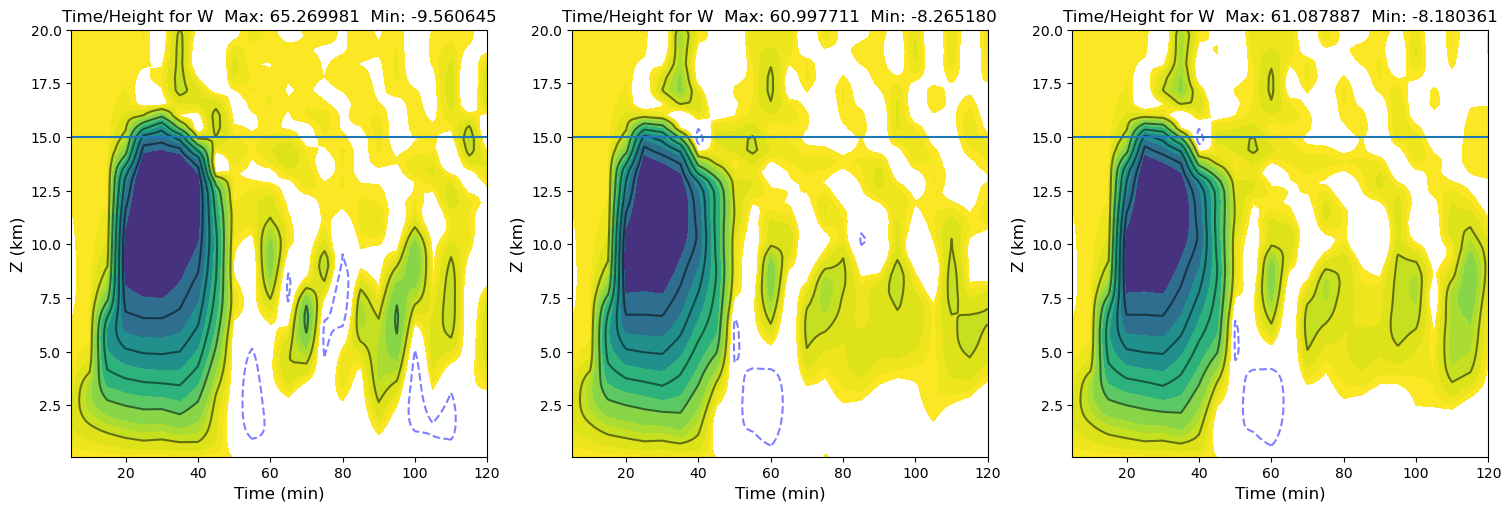

In [14]:
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 70]

fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(15,5))

iloc, jloc = 80,80

#
time1 = dims['time']/60.
time = np.tile(time1, (60,1)).transpose()

#

z3d    = dims.delz.values[:,::-1,:,:]
z3d    = np.cumsum(z3d,axis=1)

w_col = ds['w'][:,:,jloc, iloc]
z_col = z3d[:,:,jloc, iloc] * 0.001
wplot(time1, z_col, w_col, ax=ax[0])

#
w_col2 = ds2['w'][:,:,jloc, iloc]
z3d    = dims2.delz.values[:,::-1,:,:]
z3d    = np.cumsum(z3d,axis=1)
z_col2  = z3d[:,:,jloc, iloc] * 0.001
wplot(time1, z_col2, w_col2, ax=ax[1])

z3d    = dims3.delz.values[:,::-1,:,:]
z3d    = np.cumsum(z3d,axis=1)
z_col3 = z3d[:,:,jloc, iloc] * 0.001
w_col3 = ds3['w'][:,:,jloc, iloc]

wplot(time1, z_col3, w_col3, ax=ax[2])

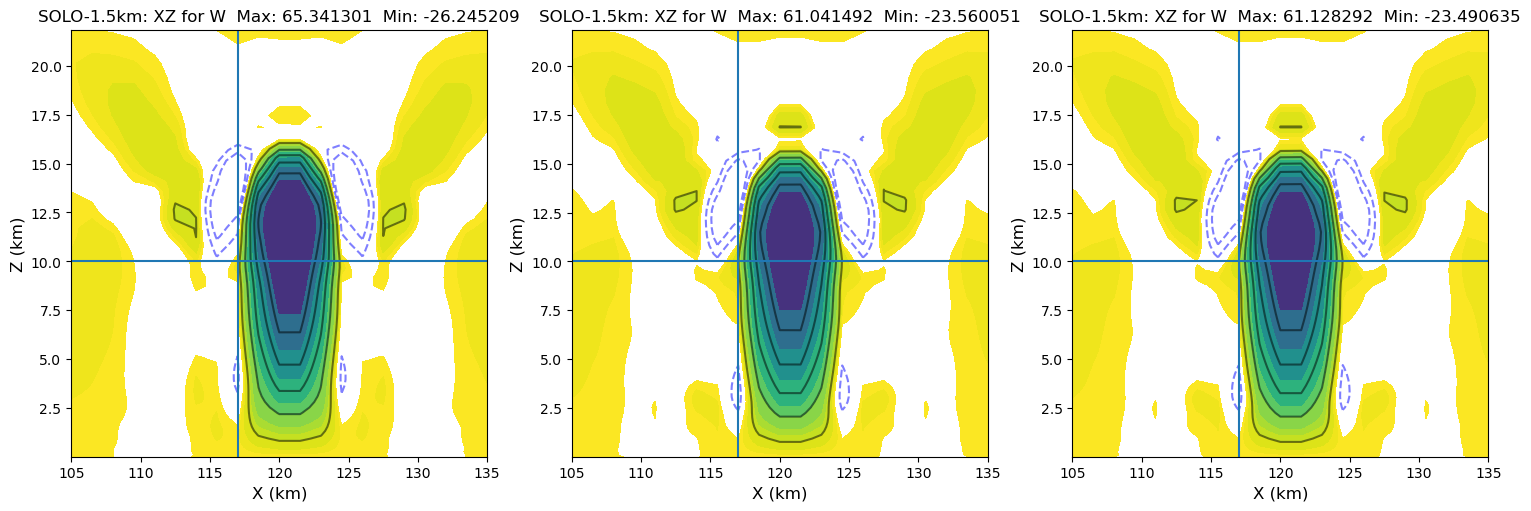

In [82]:
fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(15,5))

tloc, jloc = 5, 80

x = np.tile(solo_1km[0][1]['grid_xt'], (60,1))*1.5

for n in np.arange(3):

    w_col = solo_1km[n][0]['w'][tloc,:,jloc, :]
    z_col = solo_1km[n][0]['hgt'][tloc,:,jloc, :] * 0.001

    plot_w_xz(x, z_col, w_col, ax=ax[n], title='SOLO-1.5km', range=[105,135])
    ax[n].axvline(x=117)

In [ ]:
# Plot histograms

fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(15,5))
ax[0].hist(w_col, bins=10, edgecolor='black')
ax[1].hist(w_col2, bins=10, edgecolor='black')
ax[2].hist(w_col3, bins=10, edgecolor='black')
plt.show()